# War Modeling
## Money or Soldiers : What's more important

<img src="https://ipython-books.github.io/pages/chapter06_viz/04_d3_files/D3.png" width=500px>

**Group members:** 
<br>Jonathan Le Roux
<br>Pranav Agarwal
<br>Bhavya Jain
<br>Ethan Hecht

In [73]:
import pandas as pd
import numpy as np
import networkx as nx
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import math


## Territory Class

The first class that we are using is the territory class. In the real world a "territory" would be akin to state. The territory class has a few methods and attributes which are used to store data about each object. These are discussed in the docstrings

In [74]:
class Territory:
    """
    Class that houses the information for each individual territory of a country
    
    Attributes:
    name - The name of the territory.
    deaths - The number of soldiers that are part of the territory that have died. This value will be used in the country class 
             in order to track the number of deaths a country has during the war period
    position - a list in the form longitude, latitude
    intitial_population - the initial population of a territory. A percentage of this value is going 
                          to be used in order to determine the starting number of soldiers in each territory
    num_soldiers - the number of soldiers a territory has
    mean_skill_level - the value that will be used in order to create the distribution of skill levels in the initial creation of a territory.
    money - the money a territory currently posseses.
    prev_money - the money a territory possed before the previous attack/defense
    population_growth_rate - the population growth rate used to increase the population every year
    skill_levels - an array with the skill level of each soldier that will be used in order to determine who wins in a battle
    
    Methods:
    Constructor - creates a Territory object using a name, position, initial population ,mean_skill_level and population growth grat
    add_soldiers - increases the number of soldiers and adds the new soldiers skill levels to the dictionary
    get_position - accesses the position of the territory
    set_position - mutates the the position of the territory
    get_population - returns the population
    
    attack = improves the skill of the soldiers using money and fights oppositing territory given in the argument, updates the teritories army
             after war and returns the opposing territory with an updated army. 
             
    lose_money - removes money as a percentage of the total money of the territory and updates previous money to indicate the change
    to_string - a method to display the name, location and number of soldiers in each territory
    """
    def __init__(self,name, position, initial_population, mean_skill_level = 0.3, population_growth_rate = 0.001):
        
        self.population = initial_population
        self.position = position
        self.name = name
        self.money = 1
        
        self.deaths =0
        
        #below sets each soldier skill level randomly
        self.num_soldiers = int(0.005*initial_population)
        self.mean_skill_level = mean_skill_level
        self.prev_money = self.money
        self.skill_levels = np.abs(np.random.normal(mean_skill_level, 0.2, self.num_soldiers))
        self.population_growth_rate = population_growth_rate
               
    def get_position(self):
        return self.position
    
    def set_position(self, position):
        self.position = position
        
    def get_population(self):
        return self.population
    
    def get_num_soldiers(self):
        return len(self.skill_levels)
    
    def add_soldiers(self, mean_skill_level=0.2):
        number = 0
        if (len(self.skill_levels) < 0.005 * self.population):
            number = int((0.005 * self.population) - len(self.skill_levels))
            self.skill_levels = np.append(self.skill_levels, np.abs(np.random.normal(mean_skill_level, 0.2, number)))
        return number  
            
    def add_population(self):
        self.population = self.population_growth_rate * self.population
        
            
    def attack(self, opposing_territory):
        #changes skill level
        if self.money > opposing_territory.money :
            self.skill_levels = self.skill_levels * self.money/opposing_territory.money
            self.lose_money(0.05)
        else:
            opposing_territory.skill_levels = opposing_territory.skill_levels * opposing_territory.money/self.money
            opposing_territory.lose_money(0.05)
        #returns the winner
        attack = np.copy(self.skill_levels)
        defend = np.copy(opposing_territory.skill_levels)
        #randomizing the attack pattern of two armies
        np.random.shuffle(attack) 
        np.random.shuffle(defend)
        death_a, death_d = 0,0
       
        #run loop for minimum length steps till one of the army dies completely
        while attack.size!=0 and defend.size!=0:
            soldier1, soldier2 = attack[0], defend[0]
            probability = np.random.random()
            if soldier1/(soldier1 + soldier2) > probability:
                defend = np.delete(defend, 0)
                death_d += 1
            else:
                attack = np.delete(attack, 0)
                death_a += 1
                
        self.deaths += death_a
        opposing_territory.deaths += death_d
                
        self.skill_levels = attack
        opposing_territory.skill_levels = defend
        self.population = self.population - death_a
        opposing_territory.population = opposing_territory.population - death_d
        self.lose_money()
        opposing_territory.lose_money()
        if len(defend) == 0 :
            return self, opposing_territory
        else:
            return opposing_territory, self
        
    def lose_money(self, percent = 0.1):
        self.prev_money = np.copy(self.money)
        self.money -= self.money * percent
    
    def to_string(self):
        return ("Name: " +  str(self.name)+  " is at position "+  str(self.position) + " with " + str(self.get_num_soldiers()) + ' soldiers ')    
       
        

## Country

A country is a collection of territories. This class uses composition in order to model the real world. If a Country loses a territory it will not lose a war. The war is not lost until the all the territories are lost 

In [75]:
class Country:
    
    """
    Class that houses the information for each individual country
    
    Attributes: 
    name - the name of the country
    deaths - the total casualties sustained by the country
    money - tells the amount of money a country starts off with
    GDP_increase - the amount the country's GDP increases per year. 
    territory_list: The territories the country possesses.
    
    
    Methods:
    add_territory/remove_territory: Adds/Remove territory from the country.
    dist_money - equally distributes the money of a country to all territories
    add_GDP: increases money of the country
    lose_money/add_money: This changes money depending on country winning/losing a war.
    lose_battle_money - a method so that a country that wins a battle still suffers a loss of currency in the war
    increase_soldiers -  a method to increase the number of soliders of each territory in the country
    to_string - a method to easily display the country in terms of its territories
    """
    
    def __init__(self, name, territory_list, money, GDP_increase = 0.005):
        self.name = name
        self.deaths = 0
        self.territory_list = territory_list
    # Territory list will be initialzied as an attribute (List will come from terriotry class that Jonathan will make)
        self.money = money
    # Will be a number of money for the entire country in millions (again initialized once composition is used with Jonathan's territory class)
        self.GDP_increase = GDP_increase
    
    def add_territory(self, territory):
        self.territory_list.append(territory)
        self.money = self.money + territory.money
        
    def remove_territory(self, territory): 
        self.territory_list.remove(territory)
        self.money = self.money - territory.money
        self.deaths += territory.deaths
    
    def dist_money(self):
        # Once a territory wins/loses a battle the country needs to redistribute the money it has evenly over the number of territories
        money_per_territory = self.money / len(self.territory_list)
        for territory in self.territory_list:
            territory.money = money_per_territory
        
    def add_GDP(self):
        self.money += self.GDP_increase * self.money       

    def to_string(self):
        temp = ""
        for i in self.territory_list:
            temp += i.to_string()  + "\n"
            
        return temp
    
    def increase_soldiers(self):
        for terr in self.territory_list:
            terr.add_population()
            self.deaths += terr.add_soldiers()
            
    def add_money(self,amount):
        self.money += amount
        
    def remove_money(self,amount):
        self.money -= amount
        
    def lose_battle_money(self,territory,percent=0.1):
        self.money -= territory.money * percent

## Data 1 (from territory data.csv)

In [76]:
"""
This is going to be our data for the simulation. The simulation has an equal number of territories each with different populations. 
The country's a differentiated using the last column of the file name. This is a function in order to run simulations at mass scale at a later time.
"""

def take_in_data(file_name,country1_money,country2_money):

    territory_data = pd.read_csv(file_name)
    territory_data = territory_data.replace(0,"Country1")
    territory_data = territory_data.replace(1,"Country2")

    country_1_territory_list = []
    country_2_territory_list = []

    for i in range(len(territory_data)):
        if territory_data["country"][i] == "Country1":
            temp_Territory = Territory(territory_data["name"][i], [territory_data["longitude"][i],territory_data["latitude"][i] ],territory_data["population"][i])
            country_1_territory_list.append(temp_Territory)
        else:
            temp_Territory = Territory(territory_data["name"][i], [territory_data["longitude"][i],territory_data["latitude"][i] ],territory_data["population"][i])
            country_2_territory_list.append(temp_Territory)

    Country1 = Country('Red',country_1_territory_list,country1_money)
    Country2 = Country('Blue',country_2_territory_list,country1_money)
    
    return [Country1,Country2]

## Making Graph

In [77]:
def make_graph(Country1_list, Country2_list, draw = False):
    ''' Uses the two territories lists to make a color coded networkx graph and adds suitable edges
    to identify possible opposing territories and close neighbors. A territory can fight with
    another one if they are connected by an edge and are in different countries.
    '''
    Country1_dict = dict()
    Country1_pos = dict()
    all_pos = dict()
    for ter in Country1_list:
        Country1_dict[ter.name] = []
        Country1_pos[ter.name] = ter.position
        all_pos[ter.name] = ter.position
    Country2_dict = dict()
    Country2_pos = dict()
    for ter in Country2_list:
        Country2_dict[ter.name] = []
        Country2_pos[ter.name] = ter.position
        all_pos[ter.name] = ter.position
    
    if len(Country1_dict.keys()) != 0 and len(Country2_dict.keys()) != 0:
    
        G1 = nx.Graph(Country1_dict)
        G2 = nx.Graph(Country2_dict)
        G = nx.compose(G1,G2)
        #color code the two different countries
        node_color_dict = {}
        for node in G1.nodes():
            node_color_dict[node] = 'red'
        for node in G2.nodes():
            node_color_dict[node] = 'blue'

        node_colors = [node_color_dict[node] for node in G.nodes()]


        #add edge if two nodes are less than 20 units apart
        for node1, coords1 in all_pos.items():
            for node2, coords2 in all_pos.items():
                if node1 != node2:
                    distance = np.sqrt((coords1[0]-coords2[0])**2+(coords1[1]-coords2[1])**2)
                    if distance <= 20:
                        G.add_edge(node1, node2)


        #identify and add edge with the closest enemy territory
        closest_neighbors_Country1 = []
        for ter1,coords1 in Country1_pos.items():
            distances = []
            for ter2,coords2 in Country2_pos.items():
                distance = np.sqrt((coords1[0]-coords2[0])**2+(coords1[1]-coords2[1])**2)
                distances.append(distance)
            if len(distances) != 0:
                closest_dist = min(distances) 
                closest_neighbor_key = list(Country2_pos.keys())[distances.index(closest_dist)]
                closest_neighbors_Country1.append(closest_neighbor_key)

        closest_neighbors_Country2 = []
        for ter1,coords1 in Country2_pos.items():
            distances = []
            for ter2,coords2 in Country1_pos.items():
                distance = np.sqrt((coords1[0]-coords2[0])**2+(coords1[1]-coords2[1])**2)
                distances.append(distance)
            if len(distances) != 0:
                closest_dist = min(distances)
                closest_neighbor_key = list(Country1_pos.keys())[distances.index(closest_dist)]
                closest_neighbors_Country2.append(closest_neighbor_key)
        for i in range(len(Country1_pos.keys())):
            if len(Country1_pos.keys()) != 0:
                G.add_edge(list(Country1_pos.keys())[i],closest_neighbors_Country1[i])
            else:
                break
        for i in range(len(Country2_pos.keys())):
            if len(Country2_pos.keys()) != 0:
                G.add_edge(list(Country2_pos.keys())[i],closest_neighbors_Country2[i])
            else:
                break


        if draw == True:
            nx.draw(G, pos = all_pos, node_color=node_colors, with_labels = True)

        return G
    
    elif len(Country1_dict.keys()) != 0:
        G = nx.Graph(Country1_dict)
        nx.draw(G, pos = all_pos, node_color= 'red')
        return G
    else:
        G = nx.Graph(Country2_dict)
        nx.draw(G, pos = all_pos, node_color= 'blue')
        return G
        
        

In [78]:
Country1, Country2 = take_in_data("Territory data.csv",1000,1000)
print("Country1 territories: ")
print(Country1.to_string())
print("\nCountry2 territories: ")
print(Country2.to_string())

Country1 territories: 
Name: C is at position [127.6681281, 26.1288392] with 756 soldiers 
Name: E is at position [118.641319, 24.735427] with 979 soldiers 
Name: H is at position [-41.1547688, -21.0209448] with 769 soldiers 
Name: I is at position [6.1654992, 49.0858197] with 949 soldiers 
Name: M is at position [20.8993932, 45.1201746] with 508 soldiers 
Name: N is at position [106.0346285, -6.7523072] with 503 soldiers 
Name: O is at position [27.0855305, 48.3611707] with 811 soldiers 
Name: P is at position [139.4593556, 36.1029484] with 872 soldiers 
Name: Q is at position [51.014934, 36.7498896] with 954 soldiers 
Name: R is at position [-79.6558242, 43.4794825] with 636 soldiers 


Country2 territories: 
Name: A is at position [18.8244645, 49.9466816] with 660 soldiers 
Name: B is at position [114.462061, 36.639033] with 879 soldiers 
Name: D is at position [5.4352554, 51.9094928] with 755 soldiers 
Name: F is at position [119.196466, 32.501495] with 818 soldiers 
Name: G is at 

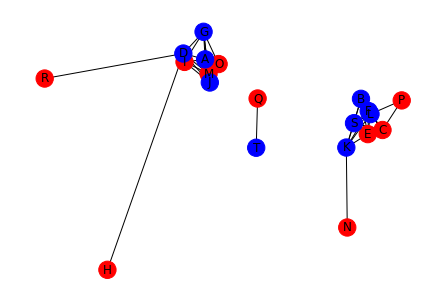

In [79]:
#Initial Base
make_graph(Country1.territory_list, Country2.territory_list, True)

## WAR FUNCTION

In [80]:
#WAR!!
def War(Country1,Country2):
    
    #Distribute Money to territories
    Country1.dist_money()
    Country2.dist_money()
    
    #Start the animation
    start = time.time()
    fig=plt.figure(figsize=(10,5))
    
    #each iteration is a year
    years = 0
    truth_value = True
    #loop until one country wins all the territories
#     while len(Country1.territory_list) != 0 and len(Country2.territory_list) != 0:
#     while Country1.money > 0 and Country2.money > 0:
    for count in range(800):
        #plot the Map
        G = make_graph(Country1.territory_list, Country2.territory_list,draw=True)
        clear_output(wait=True)
        display(fig)
        fig.clear()
        time.sleep(0.001)
        
        #randomizing the countries and territories to attack
        countries = [Country1, Country2]
        attacking_country = np.random.choice(countries)
        countries.remove(attacking_country)
        defending_country = countries[0]
        attacking_territory = np.random.choice(attacking_country.territory_list)
        possible_opponents = []
        for def_ter in defending_country.territory_list:
            if G.has_edge(attacking_territory.name, def_ter.name) == True:
                possible_opponents.append(def_ter)
        defending_territory = np.random.choice(possible_opponents)
        
        #one battle
        winning_territory = attacking_territory.attack(defending_territory)[0]
        losing_territory = attacking_territory.attack(defending_territory)[1]
        
        #adding and removing territories from the countries
        for country in [Country1,Country2]:
            if winning_territory in country.territory_list:
                winning_country = country
        if winning_country == Country1:
            Country1.add_territory(losing_territory)
            Country2.remove_territory(losing_territory)
            Country1.lose_battle_money(winning_territory)
        else:
            Country2.add_territory(losing_territory)
            Country1.remove_territory(losing_territory)
            Country2.lose_battle_money(winning_territory)
            
        #stop if one of the country wins
        if len(Country1.territory_list) == 0 or len(Country2.territory_list) == 0:
            make_graph(Country1.territory_list, Country2.territory_list,draw=True)
            clear_output(wait=True)
            display(fig)
            fig.clear()
            time.sleep(0.001)
            break
       

        #increase GDP of the country
        Country1.add_GDP()
        Country2.add_GDP()

        #Distribute Money
        Country1.dist_money()
        Country2.dist_money()

        #Increase Population and Soldiers
        Country1.increase_soldiers()
        Country2.increase_soldiers()
            
        years +=1



    end = time.time()
    print(years)  

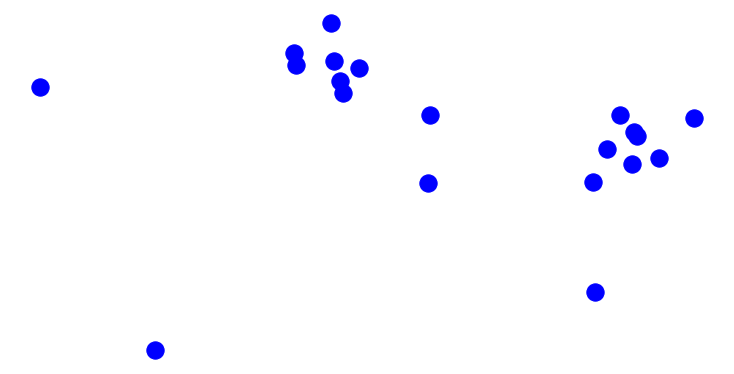

649


<Figure size 720x360 with 0 Axes>

In [81]:
"""
The visualization of war of time. This is what is happening for each time step where 2 countries are fighting over territory
"""
War(Country1,Country2)

In [82]:
'''
this is a copy of the war but it does not display anything. 
it instead returns a number of years and mutates the country1 and country2 to make running simulations less compuationally intensive.
'''
def War_no_vis(Country1,Country2):
    
    #Distribute Money to territories
    Country1.dist_money()
    Country2.dist_money()
    
    #Start the animation
    
    #each iteration is a year
    years = 0
    truth_value = True
    #loop until one country wins all the territories
#     while len(Country1.territory_list) != 0 and len(Country2.territory_list) != 0:
#     while Country1.money > 0 and Country2.money > 0:
    for count in range(800):
        #plot the Map
        G = make_graph(Country1.territory_list, Country2.territory_list,draw=False)
        
        #randomizing the countries and territories to attack
        countries = [Country1, Country2]
        attacking_country = np.random.choice(countries)
        countries.remove(attacking_country)
        defending_country = countries[0]
        attacking_territory = np.random.choice(attacking_country.territory_list)
        possible_opponents = []
        for def_ter in defending_country.territory_list:
            if G.has_edge(attacking_territory.name, def_ter.name) == True:
                possible_opponents.append(def_ter)
        defending_territory = np.random.choice(possible_opponents)
        
        #one battle
        winning_territory = attacking_territory.attack(defending_territory)[0]
        losing_territory = attacking_territory.attack(defending_territory)[1]
        
        #adding and removing territories from the countries
        for country in [Country1,Country2]:
            if winning_territory in country.territory_list:
                winning_country = country
        if winning_country == Country1:
            Country1.add_territory(losing_territory)
            Country2.remove_territory(losing_territory)
            Country1.lose_battle_money(winning_territory)
        else:
            Country2.add_territory(losing_territory)
            Country1.remove_territory(losing_territory)
            Country2.lose_battle_money(winning_territory)
            
        #stop if one of the country wins
        if len(Country1.territory_list) == 0 or len(Country2.territory_list) == 0:
            break
            
        #increase GDP of the country
        Country1.add_GDP()
        Country2.add_GDP()
        
        #Distribute Money
        Country1.dist_money()
        Country2.dist_money()
        
        #Increase Population and Soldiers
        Country1.increase_soldiers()
        Country2.increase_soldiers()
        
        years +=1

    return years



In [83]:
"""
This functions will run a number of simulations on the data that we provide it so that we can get an appoximate win % 
of the factors at play. We can then use the functions later on that are built off of these to customize the territories since 
we do not have text files with specific values

"""
def run_sims(num_sims,amount1,amount2):

    CountryA_death_array = np.zeros(num_sims)
    CountryB_death_array = np.zeros(num_sims)
    CountryA_money_array = np.zeros(num_sims)
    CountryB_money_array = np.zeros(num_sims)
    years_of_war = np.zeros(num_sims)
    winner_of_war = []

    for i in range(num_sims):
        Country1, Country2 = take_in_data("Territory data.csv",amount1,amount2)
        years_of_war[i] = War_no_vis(Country1,Country2)
        CountryA_death_array[i] = (Country1.deaths)
        CountryB_death_array[i] = (Country2.deaths)
        CountryA_money_array[i] = Country1.money
        CountryB_money_array[i] = Country2.money
        
        if len(Country1.territory_list) != 0 :
            winner_of_war.append(Country1.name)   
        else:
            winner_of_war.append(Country2.name)
            
    data={"A_deaths":CountryA_death_array,
          "B_deaths": CountryB_death_array,
          "A_money": CountryA_money_array,
          "B_money" : CountryB_money_array,
          "years_of_war" :years_of_war,
          "winner": winner_of_war}
        
    df = pd.DataFrame(data)
    return df

In [84]:
#run simulations for 1000 times
df = run_sims(50,100000,100000)
#theres a chance that nobody wins so we remove this case
df = df[df["years_of_war"]!= 800]
df.describe()

,A_deaths,B_deaths,A_money,B_money,years_of_war
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,163424.945946,165259.054054,200828.140917,121637.190817,428.135135
std,77415.909072,77979.486136,162655.773747,155676.083188,200.985649
min,44322.000000,51982.000000,4262.092482,4609.396073,115.000000
25%,101198.000000,99313.000000,8248.724845,6782.259448,259.000000
50%,154144.000000,161113.000000,254470.727618,8111.100700,413.000000
75%,225078.000000,232738.000000,320692.362652,255743.704892,597.000000
max,315547.000000,323207.000000,456077.074173,446586.549608,795.000000


In [85]:
print("when there is constant money:")
start_data= pd.read_csv("Territory data.csv")

print("Country 1")
print("started with a population of: ", sum(start_data["population"][start_data["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")
print("Mean number of casualties per war:" , np.mean(df['A_deaths']))

print("Country 2")
print("started with a population of: ", sum(start_data["population"][start_data["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")
print("Mean number of casualties per war:" , np.mean(df['B_deaths']))

when there is constant money:
Country 1
started with a population of:  1548436
wins : 62.16 % of the time
Mean number of casualties per war: 163424.94594594595
Country 2
started with a population of:  1533119
wins:  37.84 % of the time
Mean number of casualties per war: 165259.05405405405


In [87]:

def run_sims_constant_soldiers(num_sims, amount1,amount2):
    """
    This is the same as the run_sims but instead it makes all teritories have the same population
    """
    CountryA_death_array = np.zeros(num_sims)
    CountryB_death_array = np.zeros(num_sims)
    CountryA_money_array = np.zeros(num_sims)
    CountryB_money_array = np.zeros(num_sims)
    years_of_war = np.zeros(num_sims)
    winner_of_war = []

    for i in range(num_sims):
        territory_data = pd.read_csv("Territory data.csv")
        territory_data = territory_data.replace(0,"Country1")
        territory_data = territory_data.replace(1,"Country2")

        country_1_territory_list = []
        country_2_territory_list = []

        for j in range(len(territory_data)):
            if territory_data["country"][j] == "Country1":
                temp_Territory = Territory(territory_data["name"][j], [territory_data["longitude"][j],territory_data["latitude"][j] ],150000)
                country_1_territory_list.append(temp_Territory)
            else:
                temp_Territory = Territory(territory_data["name"][j], [territory_data["longitude"][j],territory_data["latitude"][j] ],150000)
                country_2_territory_list.append(temp_Territory)

        Country1 = Country('Red',country_1_territory_list,amount1)
        Country2 = Country('Blue',country_2_territory_list,amount2)
        
        years_of_war[i] = War_no_vis(Country1,Country2)
        CountryA_death_array[i] = (Country1.deaths)
        CountryB_death_array[i] = (Country2.deaths)
        CountryA_money_array[i] = Country1.money
        CountryB_money_array[i] = Country2.money
        
        if len(Country1.territory_list) != 0 :
            winner_of_war.append(Country1.name)   
        else:
            winner_of_war.append(Country2.name)
            
    data={"A_deaths":CountryA_death_array,
          "B_deaths": CountryB_death_array,
          "A_money": CountryA_money_array,
          "B_money" : CountryB_money_array,
          "years_of_war" :years_of_war,
          "winner": winner_of_war}
        
    df = pd.DataFrame(data)
    return df

In [88]:
df = run_sims_constant_soldiers(50,1000000,200000)
df = df[df["years_of_war"]!=800]
df.describe()

,A_deaths,B_deaths,A_money,B_money,years_of_war
count,50.000000,50.000000,5.000000e+01,50.000000,50.000000
mean,4230.000000,11730.000000,1.205055e+06,14546.076444,20.280000
std,3040.894739,3040.894739,9.871646e+03,4755.037783,8.109053
min,0.000000,7500.000000,1.191082e+06,6632.804736,9.000000
25%,1500.000000,9000.000000,1.197616e+06,9780.676022,13.000000
50%,3750.000000,11250.000000,1.203798e+06,15951.994969,19.000000
75%,6000.000000,13500.000000,1.209656e+06,18268.734381,25.000000
max,12750.000000,20250.000000,1.236258e+06,21139.682617,43.000000


In [89]:
print("At the same initial populations")
print("Country 1")
print("started with $", 1000000)
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 200000)
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

At the same initial populations
Country 1
started with $ 1000000
wins : 100.0 % of the time
Country 2
started with $ 200000
wins:  0.0 % of the time


In [92]:
print('what does better 15000 more soliders or  2x the money')
df = run_sims(100,400000,200000)
df = df[df["years_of_war"]!=800]
df.describe()

what does better 15000 more soliders or  2x the money


,A_deaths,B_deaths,A_money,B_money,years_of_war
count,73.000000,73.000000,7.300000e+01,7.300000e+01,73.000000
mean,158001.767123,159966.986301,7.840729e+05,4.896402e+05,417.657534
std,68304.734727,67650.479090,6.181436e+05,6.240356e+05,184.977493
min,20650.000000,28310.000000,1.733693e+04,1.724750e+04,61.000000
25%,114141.000000,108685.000000,3.223125e+04,2.555596e+04,289.000000
50%,162188.000000,158862.000000,9.872851e+05,3.510698e+04,411.000000
75%,195635.000000,196716.000000,1.254092e+06,1.120072e+06,515.000000
max,291609.000000,298547.000000,1.770360e+06,1.802083e+06,769.000000


In [93]:
print("Country 1")
print("started with $", 400000)
print("started with a population of: ", sum(start_data["population"][start_data["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 200000)
print("started with a population of: ", sum(start_data["population"][start_data["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

Country 1
started with $ 400000
started with a population of:  1548436
wins : 63.01 % of the time
Country 2
started with $ 200000
started with a population of:  1533119
wins:  36.99 % of the time


In [94]:
def run_sims_2(num_sims,amount1,amount2):
    """
    same method as run sims but uses a different data file
    """
    CountryA_death_array = np.zeros(num_sims)
    CountryB_death_array = np.zeros(num_sims)
    CountryA_money_array = np.zeros(num_sims)
    CountryB_money_array = np.zeros(num_sims)
    years_of_war = np.zeros(num_sims)
    winner_of_war = []

    for i in range(num_sims):
        Country1, Country2 = take_in_data("Territory-data-2.csv",amount1,amount2)
        years_of_war[i] = War_no_vis(Country1,Country2)
        CountryA_death_array[i] = (Country1.deaths)
        CountryB_death_array[i] = (Country2.deaths)
        CountryA_money_array[i] = Country1.money
        CountryB_money_array[i] = Country2.money
        
        if len(Country1.territory_list) != 0 :
            winner_of_war.append(Country1.name)   
        else:
            winner_of_war.append(Country2.name)
            
    data={"A_deaths":CountryA_death_array,
          "B_deaths": CountryB_death_array,
          "A_money": CountryA_money_array,
          "B_money" : CountryB_money_array,
          "years_of_war" :years_of_war,
          "winner": winner_of_war}
        
    df = pd.DataFrame(data)
    return df

In [95]:
#what does better 15000 more soliders or  more money per territory
df = run_sims_2(100,400000,400000)
df = df[df["years_of_war"]!=800]
df.describe()
start_data_2= pd.read_csv("Territory-data-2.csv")

In [96]:
print("At the same initial populations")
print("Country 1")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_2["population"][start_data_2["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_2["population"][start_data_2["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

At the same initial populations
Country 1
started with $ 400000
started with a population of:  1889756
wins : 17.86 % of the time
Country 2
started with $ 400000
started with a population of:  1191799
wins:  82.14 % of the time
